## Überlick
**Allgemein:** Viele Cyber-Physikalische Produktionssysteme (Cyber-Physical Production System, CPPS) enthalten wichtige Komponenten, die mit der Zeit verschleißen. Meistens haben die einzelnen Komponenten eine geschätzte Lebensdauer, bevor sie ersetzt werden. Aufgrund der variablen Produktkomplexität, unterschiedlicher Materialien, Arbeitsbelastungen oder unterschiedlicher Umgebungsbedingungen können sie jedoch ungenau sein. Eine nicht rechtzeitig ausgetauschte Komponente führt dazu, dass unnötige Ausfallzeiten aufgrund von Reparaturen entstehen oder die Produktion/Maschine ausfällt. Deshalb ist es sinnvoll, den Zustand der einzelnen Komponenten mit Hilfe von Sensoren kontinuierlich zu überwachen.

**Problem:** Insbesondere, wenn die Maschine selbst unregelmäßig gewechselt wird oder auswechselbare Teile mit leicht unterschiedlichen Spezifikationen verwendet werden, kann die manuelle Modellierung des Verschleißes mühsam und zeitaufwendig sein. Im Vergleich dazu bieten maschinelle Lernverfahren einen Weg zur automatischen Modellerstellung. Diese Techniken können schnell neu gelernt werden, wenn ein Systemwechsel dies erforderlich macht. In diesem Notebook wird die Idee von [1] aufgegriffen und die Maschinendaten des neuen und funktionierenden CPPS gelernt. Anstelle einer selbstorganisierenden Karte (Self-organizing Map, SOM) wird als Modell ein Autoencoder verwendet.

**Ziel:** Die Maschine gruppiert lose Flaschen oder Dosen in festgelegte Packungsgrößen, wickelt sie in Plastikfolie ein und schrumpft dann die Plastikfolie durch Heißluft zu einem Paket zusammen. Die Plastikfolie wird der Maschine von großen Spulen zugeführt und dann auf die Länge geschnitten, die erforderlich ist, um die Folie um ein Warenpaket zu wickeln. Die Schneidevorrichtung der Maschine ist ein wichtiger Bestandteil und muss daher ordnungsgemäß eingerichtet und gewartet werden. Das Messer kann jedoch während des Betriebs nicht visuell inspiziert werden, da es von einem Metallgehäuse umschlossen ist und eine hohe Rotationsgeschwindigkeit aufweist. Das Ziel ist es, basierend auf einer kontinuierlichen Überwachung der Schneidklingen die Zuverlässigkeit der Maschine zu erhöhen und unerwartete Ausfallzeiten, die durch fehlgeschlagene Schnitte verursacht werden, zu reduzieren.

<img src="fig/VegaHT60.png" width=900 />

Bildquelle: [OCME’s VegaHT’s Shrink-Wrapper](http://improve-vfof.eu/project/use-cases/ocme/)

## Notebook Vorbereitung
In diesem Notebook wird das Tensorflow-Framework angewendet. Zuerst werden alle erforderlichen Bibliotheken importiert:

In [1]:
# Preliminary steps
# Common imports
import numpy as np
import pandas as pd 

# Import sklearn
import sklearn
from sklearn.datasets import load_files
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
assert tf.__version__ >= "2.0"

# To plot pretty figures
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

## Blick auf die Datenstruktur
Die Dateien im Datensatz haben das Format ```mmmBladeNNN.csv```, wobei `mmm` für den aktuellen Gesundheitszustand der Klinge (new, worn) und ```NNN``` für die Nummer der Aufzeichnung im Bereich von 1−3 steht. Jede Datei entspricht einer Messung von ~8 Sekunden mit einer zeitlichen Auflösung von 4ms , d.h. insgesamt 2048 Datenpunkte für jede Datei. Die Daten laden wir mit Pandas:


In [2]:
# Loading data for the new/worn blade
new = [pd.read_csv("data/NewBlade00%d.csv"%i) for i in range(1,4)]
worn = [pd.read_csv("data/WornBlade00%d.csv"%i) for i in range(1,4)]

Die ersten fünf Zeilen des DataFrames können mit der Methode `head()` ausgegeben werden:

In [3]:
new[0].head()

,Timestamp,pCut Motor: Torque,pCut CTRL Position controller: Lag error,pCut CTRL Position controller: Actual position,pCut CTRL Position controller: Actual speed,pSvolFilm CTRL Position controller: Actual position,pSvolFilm CTRL Position controller: Actual speed,pSvolFilm CTRL Position controller: Lag error
0,-0.188,-0.112131,-0.002490,-884606,0.000000,11128,2.504289,0.261085
1,-0.184,-0.088931,-0.003863,-884606,17.166138,11128,-2.504289,0.260083
2,-0.180,-0.115141,0.001630,-884606,-6.866455,11128,7.513016,0.259081
3,-0.176,-0.111815,0.003003,-884606,-13.732910,11128,-2.504289,0.260083
4,-0.172,-0.130970,0.004376,-884606,-6.866455,11128,0.000000,0.261085


In der ersten Spalte ist der Zeitstempel aufgetragen. In den weiteren Spalten gibt es sieben Merkmale: `cut torque`, `cut lag error`, `cut position`, `cut speed`, `film position`, `film speed` und `film lag error`. Die Methode `info()` hilft eine Beschreibung der Daten zu erhalten: Anzahl der Zeilen, der Typ jedes Attributs und die Anzahl der Werte, die ungleich null sind.

In [4]:
new[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Data columns (total 8 columns):
Timestamp                                               2048 non-null float64
pCut Motor: Torque                                      2048 non-null float64
 pCut CTRL Position controller: Lag error               2048 non-null float64
 pCut CTRL Position controller: Actual position         2048 non-null int64
 pCut CTRL Position controller: Actual speed            2048 non-null float64
 pSvolFilm CTRL Position controller: Actual position    2048 non-null int64
 pSvolFilm CTRL Position controller: Actual speed       2048 non-null float64
 pSvolFilm CTRL Position controller: Lag error          2048 non-null float64
dtypes: float64(6), int64(2)
memory usage: 128.1 KB


Die Methode `describe()` fasst die numerischen Merkmale der einzelnen Spalten zusammen:

In [5]:
new[0].describe()

,Timestamp,pCut Motor: Torque,pCut CTRL Position controller: Lag error,pCut CTRL Position controller: Actual position,pCut CTRL Position controller: Actual speed,pSvolFilm CTRL Position controller: Actual position,pSvolFilm CTRL Position controller: Actual speed,pSvolFilm CTRL Position controller: Lag error
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,3.906000,-0.077109,-0.000306,-881592.086426,878.606161,16150.827148,1371.617691,0.646027
std,2.365404,0.372693,0.038205,2661.658773,1317.007966,3597.327988,552.624403,0.085916
min,-0.188000,-2.292097,-0.513631,-884747.000000,-954.437256,11128.000000,-7.513016,0.259081
25%,1.859000,-0.304018,-0.009814,-884346.250000,-172.519684,12420.500000,743.789139,0.612427
50%,3.906000,-0.165394,-0.000182,-881146.000000,449.752808,16047.000000,1389.908569,0.652235
75%,5.953000,0.319277,0.009876,-879821.500000,2059.078125,19591.000000,1968.411041,0.693293
max,7.999999,0.606260,0.346109,-877098.000000,3556.823730,22360.000000,2068.584717,0.869679


## Vorbereiten der Daten

In [6]:
# Preprocessor for the data
scaler = StandardScaler()
scaler.fit(np.concatenate([new_.values for new_ in new]))

# Give each column a name
columns = ["timestamp", "cut torque", "cut lag error", "cut position",
           "cut speed", "film position", "film speed", 
           "film lag error"]

for i in range(3):
    new[i].iloc[:,1:] = scaler.transform(new[i].astype(float))[:,1:]
    worn[i].iloc[:,1:] = scaler.transform(worn[i].astype(float))[:,1:]
    new[i].columns = columns
    worn[i].columns = columns
    print("New  {0}, shape={1}".format(i+1, new[i].shape))
    print("Worn {0}, shape={1}".format(i+1, worn[i].shape))

New  1, shape=(2048, 8)
Worn 1, shape=(2048, 8)
New  2, shape=(2048, 8)
Worn 2, shape=(2048, 8)
New  3, shape=(2048, 8)
Worn 3, shape=(2048, 8)


In [7]:
data_normal = np.concatenate([new_.values for new_ in new])
n = len(data_normal)

valid_size = 20. 
valid_size = int(valid_size*n/100.) 

x_train = data_normal[:-valid_size, 1:]
x_valid = data_normal[-valid_size:, 1:]

print("Train data: {0}".format(x_train.shape))
print("Valid data: {0}".format(x_valid.shape))

Train data: (4916, 7)
Valid data: (1228, 7)


In [8]:
data_worn = np.concatenate([worn_.values for worn_ in worn])
n = len(data_worn)

x_worn = data_worn[:, 1:]
print("Data worn: {0}".format(x_worn.shape))

Data worn: (6144, 7)


## Modelldefinition und Training

### Ansatz
Bei der Anomalie-Erkennung wird zunächst das Normalverhalten der Maschine angelernt, dann werden Anomalie-Scores generiert, die zur Identifizierung ungewöhnlicher Aktivitäten verwendet werden. Der hier beschriebene Ansatz basiert auf einem Autoencoder [2]. Ein Autoencoder ist ein neuronales Netz, das unbeaufsichtigt eine niedrigdimensionale Datendarstellungen lernt. Es besteht immer aus zwei Teilen: einem Encoder und einem Decoder. Der Encoder lernt die Eingabedaten in eine interne Repräsentation zu überführen (auch als Flaschenhals oder Bottleneck bezeichnet). Der Decoder lernt die interne Repräsentation wieder in eine Ausgabe umzuwandeln. Das Trainingsziel besteht darin die Eingaben in das Netz zu rekonstruieren. Der Fehler wird auch als Rekonstruktionsfehler bezeichnet, der das Modell für Abweichungen der Rekonstruktion von den Eingaben bestraft.

<center>
    <img src="fig/autoencoder.png" width=600 />
</center>

Dieses Konzept kann verwendet werden, um z.B. mit einem Autoencoder Anomalien zu erkennen oder den Verschleiß der Komponente anzuzeigen. Hierfür wird der Autoencoder mit den normalen „gut“ Daten der Maschine trainiert, während das Modell anschließend auch an der verschlissenen Komponente getestet wird. Die Annahme ist: der Verschleiß einzelner Komponenten verursachen einen höheren Rekonstruktionsfehler. Anschließend kann der Rekonstruktionsfehler in einen geschätzten Gesundheitszustand umgewandelt werden, der aktuelle Zustand der Maschine widerspiegelt. 

<center>
    <img src="fig/autoencoder_anomaly.png" width=900 />
</center>

> **Warum einen Autoencoder anwenden?**
> 
> Mit einem Autoencoder kann das Modell weitgehend mit ungelabelten Daten trainiert werden. Dies verringert die Kosten, die mit dem Sammeln einer großen Menge an gelabelten Trainingsdaten verbunden ist. Das Problem beim aufnehmen neuer Datensätze ist:
> - Nur in wenigen Situationen werden Daten mit einem Label gekennzeichnet.
> - Menschen müssen Daten beschriften und mit Anmerkungen versehen.
> 
> Wenn eine Industrieanwendung betrachten wird, können zusätzlich folgende Probleme auftreten:
> - Häufig erfordert die Kennzeichnung umfassende Erfahrung mit bestimmten Anlagentypen, Verfahrenstypen oder sogar einzelnen Anlagen.
> - Das labeln von Daten in industriellen Anwendungen ist sehr aufwendig und kostenintensiv.
> 
> <center>
>     <img src="fig/data_label.png" width=700 />
> </center>

### Model erstellen und trainieren

In [9]:
# Define encoder
encoder = keras.models.Sequential([
    keras.layers.Dense(256, activation="elu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(5, activation="elu")
    ]) 

# Define decoder
decoder = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape = [5] ),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation="elu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(x_train.shape[1])
    ]) 

# Put together
autoencoder = keras.models.Sequential([
    encoder, decoder
    ])

# Define optimizer and compile model
autoencoder.compile(optimizer="adam", loss="mse")

In [10]:
history = autoencoder.fit(np.array(x_train),np.array(x_train),
                epochs=40,
                batch_size=64,
                shuffle=True,
                validation_split=0.1,
               )

Epoch 1/40
70/70 [==============================] - 1s 6ms/step - loss: 0.3682 - val_loss: 0.3055
Epoch 2/40
70/70 [==============================] - 0s 3ms/step - loss: 0.1872 - val_loss: 0.2689
Epoch 3/40
70/70 [==============================] - 0s 6ms/step - loss: 0.1672 - val_loss: 0.2619
Epoch 4/40
70/70 [==============================] - 0s 4ms/step - loss: 0.1598 - val_loss: 0.2507
Epoch 5/40
70/70 [==============================] - 0s 4ms/step - loss: 0.1500 - val_loss: 0.2471
Epoch 6/40
70/70 [==============================] - 0s 3ms/step - loss: 0.1404 - val_loss: 0.2480
Epoch 7/40
70/70 [==============================] - 0s 3ms/step - loss: 0.1416 - val_loss: 0.2320
Epoch 8/40
70/70 [==============================] - 0s 3ms/step - loss: 0.1378 - val_loss: 0.2431
Epoch 9/40
70/70 [==============================] - 0s 3ms/step - loss: 0.1310 - val_loss: 0.2432
Epoch 10/40
70/70 [==============================] - 0s 3ms/step - loss: 0.1294 - val_loss: 0.2371
Epoch 11/40
70/70 [

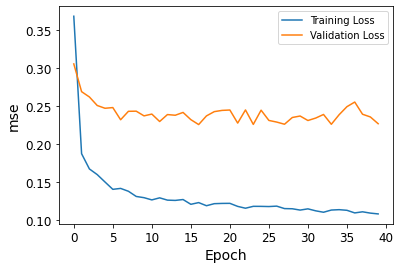

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.legend()

In [12]:
# Transform input into latent space
z_train = encoder.predict(x_train)
z_valid = encoder.predict(x_valid)
z_worn = encoder.predict(x_worn)

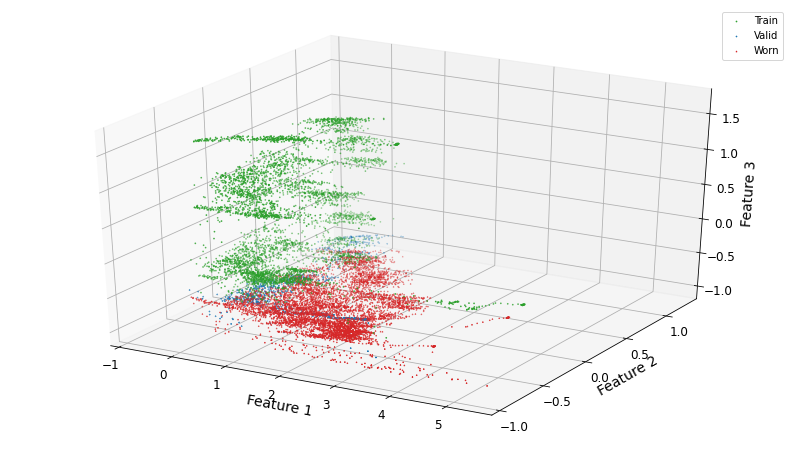

In [13]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(projection='3d')

for m, color, label, scale, z in [('o', 'tab:green', 'Train', 0.5, z_train), ('x', 'tab:blue', 'Valid', 0.5, z_valid), ('^', 'tab:red', 'Worn', 0.5, z_worn)]:
    xs = z[:,0]
    ys = z[:,3]
    zs = z[:,4]
    ax.scatter(xs, zs, ys, marker=m, s=scale, c=color, label=label)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()

plt.show()

## Anomalien erkennen
Mit fortschreitendem Training wird der Fehler zwischen dem Encoder-Eingang und dem Decoder-Ausgang für die Trainingsdaten weiter minimiert. Um die Relevanz des Trainingsprozesses für die Aufgabe der Anomalieerkennung zu veranschaulichen, kann das vom Modell erzeugte Histogramm des Rekonstruktionsfehlers visualisieren werden. In einem halb-überwachten Setup wären Labels für einen kleinen Pool von Validierungs-/Testproben vorhanden. Mit Hilfe dieser Labels (und etwas Fachwissen) lässt sich automatisch ein Schwellenwert zur Erkennung von Anomalien bestimmen.

Wenn es keine gelabelten Daten gibt und zwei Annahmen getroffen werden
- die Datenpunkte im Trainingsdatensatz repräsentieren den "gut" Zustand der Maschine und 
- der MSE folgt einer Normalverteilung), 

können statistische Daten wie Standardabweichung und Perzentile verwendet werden, um einen guten Schwellenwert abzuleiten. Der Schwellwert kann anschließend verwendet werden, um Anomalien während des Betriebs zu klassifizieren. 

In [14]:
columns_ = ["cut torque", "cut lag error", "cut position",
           "cut speed", "film position", "film speed", 
           "film lag error"]

# Reconstruction train data
x_pred = autoencoder.predict(np.array(x_train))

# Creating dataframe for reconstructed data
x_pred = pd.DataFrame(x_pred,columns = columns_)
x_pred.index = pd.DataFrame(x_train).index

# Dataframe to get the difference of predicted data and real data. 
scored_normal = pd.DataFrame(index = pd.DataFrame(x_train).index)

# Returning the mean of the loss for each column
scored_normal['Loss_mae'] = np.mean(np.abs(x_pred - x_train), axis = 1)

In [15]:
# Selecting a Threshold
train_loss = np.mean(np.abs(x_pred - x_train), axis = 1)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.2595972028119697


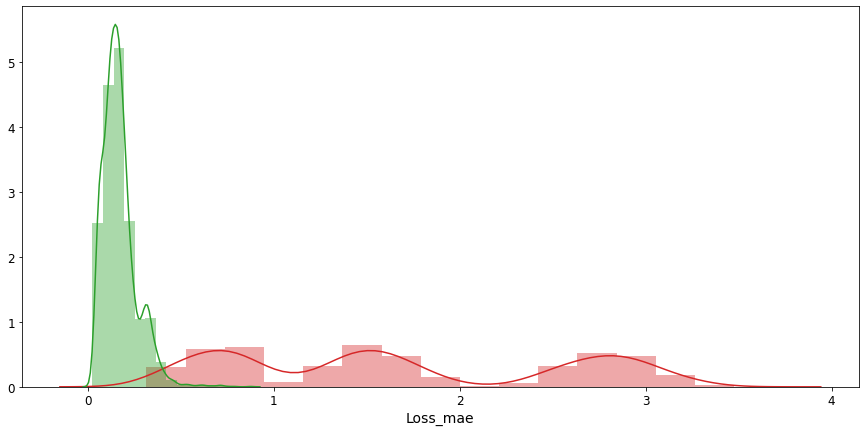

In [16]:
# Reconstruction worn data
x_pred = autoencoder.predict(np.array(x_worn))

# Creating dataframe for reconstructed data
x_pred = pd.DataFrame(x_pred,columns = columns_)
x_pred.index = pd.DataFrame(x_worn).index

# Dataframe to get the difference of predicted data and real data. 
scored_worn = pd.DataFrame(index = pd.DataFrame(x_worn).index)

# Returning the mean of the loss for each column
scored_worn['Loss_mae'] = np.mean(np.abs(x_pred - x_worn), axis = 1)

# Plot reconstruction error for worn (red) and normal (green) data
plt.subplots(figsize=(15,7))
sns.distplot(scored_worn['Loss_mae'],
            bins = 15, 
            kde= True,
            color = 'tab:red')
sns.distplot(scored_normal['Loss_mae'],
            bins = 15, 
            kde= True,
            color = 'tab:green')

In [17]:
error_normal = np.mean(np.abs(autoencoder.predict(data_normal[:,1:]) - data_normal[:,1:]), axis=1)
error_worn = np.mean(np.abs(autoencoder.predict(data_worn[:,1:]) - data_worn[:,1:]), axis=1)
error_normal_worn = np.concatenate((error_normal, error_worn))

In [18]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

error_normal_worn_avg = moving_average(error_normal_worn, 200)

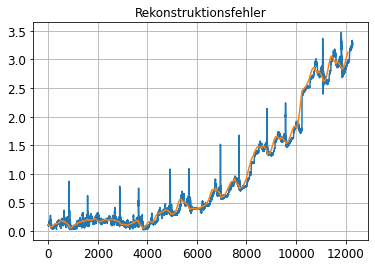

In [19]:
plt.grid()
plt.plot(error_normal_worn)
plt.plot(error_normal_worn_avg)
plt.title("Rekonstruktionsfehler")
plt.show()

### Schätzung des Gesundheitszustands

Der Rekonstruktionsfehler kann in einen geschätzten Gesundheitszustand umgewandelt werden, indem der Rekonstruktionsfehler ($L$) normalisiert wird, so dass $95\%$ der Gesundheit dem maximalen Fehler von "gut" Daten und $5\%$ dem maximalen Fehler insgesamt auf einer logistischen Skala entsprechen
$$
\text{Systemgesundheit}=\frac{1}{1+e^{\alpha L + b}} \, . 
$$

In [20]:
n = len(data_normal)

max_normal = np.amax(error_normal)
max_full = max(max_normal, np.amax(error_worn))

sh_train = 0.95
sh_worn = 0.05
expit = lambda x: 1./(1 + np.exp(-x))
logit = lambda p: np.log(p/(1 - p))

a = -(logit(sh_train) - logit(sh_worn))/(max_full - max_normal)
b = -(logit(sh_worn)*max_normal - logit(sh_train)*max_full)/(max_full - max_normal)
system_health = lambda error: 100*expit(a*error + b)

health_normal_worn = np.concatenate((system_health(error_normal[:-valid_size]), 
    system_health(error_normal[-valid_size:]),
    system_health(error_worn)
    ))

health_normal_worn_avg = moving_average(health_normal_worn, 500)

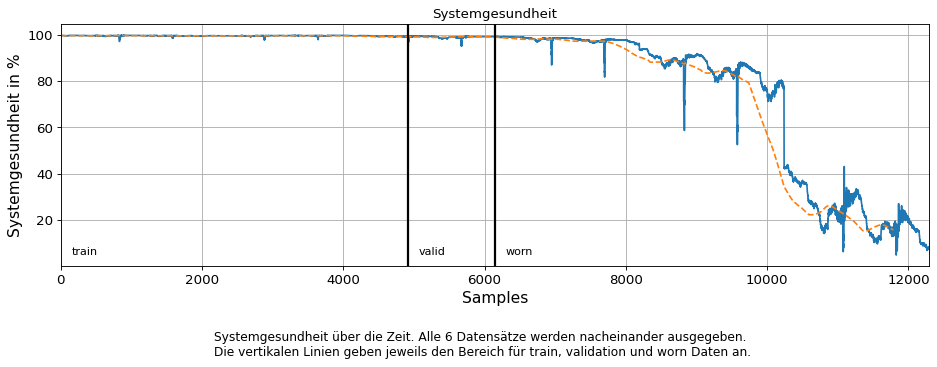

In [21]:
# Plot
plt.figure(figsize=(14, 4), dpi=80)
plt.plot(health_normal_worn)
plt.plot(health_normal_worn_avg, '--')
plt.axvline(x= n - valid_size, linewidth=2, color='k')
plt.axvline(x= n, linewidth=2, color='k')
plt.xlim(0, n + len(error_worn))

# Description
plt.title('Systemgesundheit')
plt.ylabel('Systemgesundheit in %')
plt.xlabel('Samples')
plt.figtext(0.5, -0.15, 'Systemgesundheit über die Zeit. Alle 6 Datensätze werden nacheinander ausgegeben.\n Die vertikalen Linien geben jeweils den Bereich für train, validation und worn Daten an.', wrap=True, horizontalalignment='center', fontsize=11)
plt.text( 150, 5, 'train')
plt.text( (n - valid_size) + 150, 5, 'valid')
plt.text( n + 150, 5, 'worn')
plt.grid()
plt.show()

### Lokalisierung der Anomalie
Mehr über die Störung lässt sich anhand der einzelnen Fehlerbeiträge der einzelnen Merkmale herausfinden. Dazu wird der gesamte Rekonstruktionsfehler für jeden Datenpunkt normalisiert. Die einzelnen Fehlerbeiträge können dann mit unterschiedlichen Farben dargestellt werden.

In [22]:
_, p = x_train.shape

error_normal_all = np.abs(autoencoder.predict(data_normal[:,1:]) - data_normal[:,1:])
error_worn_all = np.abs(autoencoder.predict(data_worn[:,1:]) - data_worn[:,1:])

distance_all = np.concatenate((error_normal_all, error_worn_all))
fractions = (distance_all.T/np.sum(distance_all, axis=1)).T
t = np.arange(len(fractions))

Text(0.5, -0.17, 'Normalisierter Rekonstruktionsfehler über die Zeit. Alle 6 Datensätze werden nacheinander ausgegeben.\n Die vertikalen Linien geben jeweils den Bereich für train, validation und worn Daten an. \nDer Beitrag zum Rekonstruktionsfehler ist eingefärbt.')

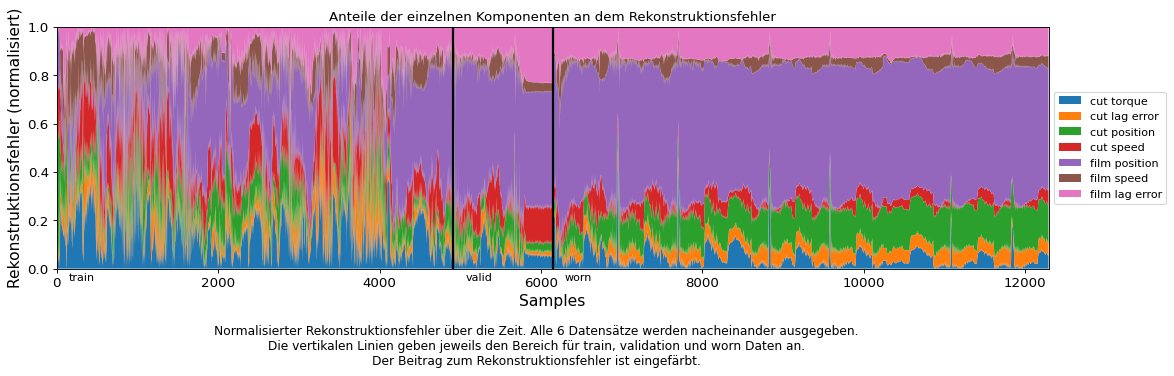

In [23]:
# Plot
plt.figure(figsize=(16, 4), dpi=80)
for j in range(p):
    lower = np.sum(fractions[:,:j], axis=1)
    upper = np.sum(fractions[:,:j + 1], axis=1)
    plt.fill_between(t, lower, upper, label=new[0].columns[j + 1])

plt.axvline(x= n - valid_size, linewidth=2, color='k')
plt.axvline(x= n, linewidth=2, color='k')
plt.xlim(0, n + len(error_worn))
plt.ylim(0, 1)

# Description
plt.title("Anteile der einzelnen Komponenten an dem Rekonstruktionsfehler")
plt.xlabel('Samples')
plt.ylabel('Rekonstruktionsfehler (normalisiert)')
plt.text( 150, -0.05, 'train', color='k')
plt.text( (n - valid_size) + 150, -0.05, 'valid', color='k')
plt.text( n + 150, -0.05, 'worn', color='k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.figtext(0.5, -0.17, 'Normalisierter Rekonstruktionsfehler über die Zeit. Alle 6 Datensätze werden nacheinander ausgegeben.\n Die vertikalen Linien geben jeweils den Bereich für train, validation und worn Daten an. \nDer Beitrag zum Rekonstruktionsfehler ist eingefärbt.', wrap=True, horizontalalignment='center', fontsize=11)

In [24]:
means = np.mean(fractions[-1000:], axis = 0)
for i, amean in enumerate(means):
    print("{0: <15s}: {1: 0.2f}%".format(new[0].columns[i + 1], amean * 100))

cut torque     :  3.65%
cut lag error  :  6.03%
cut position   :  16.73%
cut speed      :  3.09%
film position  :  54.10%
film speed     :  4.52%
film lag error :  11.88%


### Weitere Schritte
In den weiteren Schritten muss nun bewertet werden, ob die Aufgabe zufriedenstellend gelöst wurde und es muss über die nächsten Schritte beraten werden, d.h. die Überführung in einen Demonstrator oder der Beginn einer neuen Iteration des Projekts.

## Abschließende Anmerkungen
Dieser Datensatz wurde dem Forschungsprojekt IMPROVE verwendet. Er enthält Daten einer neuen und abgenutzten Schneidklinge. IMPROVE hat Mittel aus dem Forschungs- und Innovationsprogramm Horizont 2020 der Europäischen Union unter der Förderungsnummer 678867 erhalten. Der Datensatz kann auf der Seite [Kaggle](https://www.kaggle.com/inIT-OWL/vega-shrinkwrapper-runtofailure-data) heruntergeladen werden, er ist öffentlich zugänglich und kann unter den folgenden [Bedingungen](https://creativecommons.org/licenses/by-sa/3.0/) weiterverwendet werden.

## Quellen
[1] von Birgelen, Alexander; Buratti, Davide; Mager, Jens; Niggemann, Oliver: Self-Organizing Maps for Anomaly Localization and Predictive Maintenance in Cyber-Physical Production Systems. In: 51st CIRP Conference on Manufacturing Systems (CIRP CMS 2018) CIRP-CMS, May 2018.

Paper available as open access: https://authors.elsevier.com/sd/article/S221282711830307X

[2] Goodfellow, Ian; Bengio, Yoshua; Courville, Aaron: Deep learning. Chapter 14, Autoencoders. MIT Press 2016.